<a href="https://colab.research.google.com/github/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/blob/master/CW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Check GPU**

In [1]:
!!nvidia-smi

['Thu Jan 14 13:59:12 2021       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|                               |                      |               MIG M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |',
 '|                               |                      |                 ERR! |',
 '+-------------------------------+----------------------+----------------------+',
 '                                      

# **Import Libraries**

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from pj61403_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [3]:
tf.compat.v1.disable_eager_execution()

# **Hyperparameters**

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

EPOCHS = 100

BATCH_SIZE = 32

LR = 1e-4

# **Data**

## **Clone Data**

In [59]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA

Cloning into 'PJ61403_DATA'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1467 (delta 0), reused 0 (delta 0), pack-reused 1464
Receiving objects: 100% (1467/1467), 149.84 MiB | 41.75 MiB/s, done.
Resolving deltas: 100% (423/423), done.


In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-25-25

Cloning into 'PJ61403_DATA_split_50-25-25'...
remote: Enumerating objects: 404, done.
remote: Total 404 (delta 0), reused 0 (delta 0), pack-reused 404
Receiving objects: 100% (404/404), 76.59 MiB | 41.00 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (997/997), done.


In [32]:
train_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/train'

val_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val'

test_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test'

## **Data Augmentation**

In [33]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [34]:
train_generator = train_aug.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode ='categorical')

val_generator = val_aug.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='categorical')

test_generator = test_aug.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 121 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


# **Model**

## **Base Model**

In [35]:
base_model = tf.keras.models.load_model('/content/6_scratch_CW_densenet121_84_model.h5')

In [36]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [37]:
num_layers = len(base_model.layers)

## **New Model**

In [38]:
for i in range(num_layers):
    base_model.layers[i].trainable = False

x = base_model.layers[num_layers-2].output
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
prediction = Dense(4, activation='softmax')(x)

new_model = Model(inputs=base_model.input,outputs=prediction)

In [39]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

# **Compile**

In [40]:
new_model.compile(optimizer=Adam(LR), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## **Callbacks**

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='/content/pj61043_densenet121_model_cw2.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7 , patience=10, verbose=1, min_delta=1e-4, mode='min')

# **Training**

In [42]:
history = new_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        callbacks=[early_stop, model_checkpoint, reduce_lr_rate])

Epoch 1/100
4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 30.2500 - loss: 1.7873 - accuracy: 0.2479

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4/4 [==============================] - 106s 33s/step - batch: 1.5000 - size: 30.2500 - loss: 1.7873 - accuracy: 0.2479 - val_loss: 1.6911 - val_accuracy: 0.3500
Epoch 2/100
4/4 [==============================] - 3s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.6691 - accuracy: 0.3223 - val_loss: 1.6353 - val_accuracy: 0.3333
Epoch 3/100
4/4 [==============================] - 5s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.6582 - accuracy: 0.3140 - val_loss: 1.5988 - val_accuracy: 0.4000
Epoch 4/100
4/4 [==============================] - 5s 2s/step - batch: 1.5000 - size: 30.2500 - loss: 1.6365 - accuracy: 0.3306 - val_loss: 1.5780 - val_accuracy: 0.4167
Epoch 5/100
4/4 [==============================] - 5s 2s/step - batch: 1.5000 - size: 30.2500 - loss: 1.6434 - accuracy: 0.3058 - val_loss: 1.5556 - val_accuracy: 0.4833
Epoch 6/100
4/4 [==============================] - 4s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.5824 - accuracy: 0.3554 - val_loss: 1.5356 - val_accura

# **Graph**

## **Accuracy**

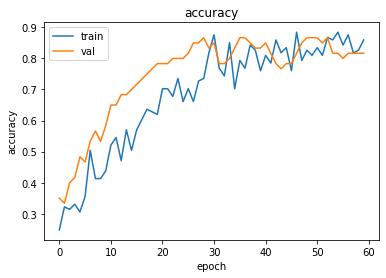

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## **Loss**

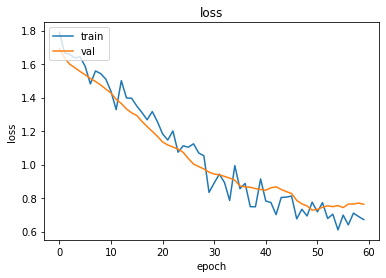

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [46]:
test_model = tf.keras.models.load_model('/content/pj61043_densenet121_model_cw2.h5')

In [47]:
num_test_files = len(test_generator.filenames)

In [48]:
test_generator.reset()

In [49]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## **Confusion Matrix**

Confusion matrix, without normalization
[[12  2  3  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 1  0  3 11]]


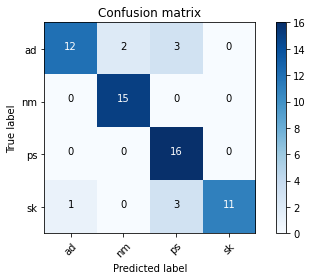

In [50]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['ad', 'nm', 'ps', 'sk']

plot_confusion_matrix(cm, classes_names, False)

Normalized confusion matrix
[[0.70588235 0.11764706 0.17647059 0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.06666667 0.         0.2        0.73333333]]


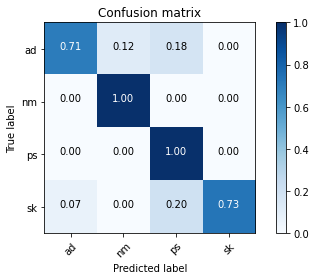

In [51]:
plot_confusion_matrix(cm, classes_names, True)

In [52]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[12  2  3  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 1  0  3 11]]
Classification Report
              precision    recall  f1-score   support

          ad       0.92      0.71      0.80        17
          nm       0.88      1.00      0.94        15
          ps       0.73      1.00      0.84        16
          sk       1.00      0.73      0.85        15

    accuracy                           0.86        63
   macro avg       0.88      0.86      0.86        63
weighted avg       0.88      0.86      0.85        63



## **Grad-CAM**

In [53]:
last_conv2d = 'conv5_block16_2_conv'

### **AD**

In [54]:
akiec_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ad/ad1.jpg'

Model prediction:
	ad             	(0)	with probability 0.508
	ps             	(2)	with probability 0.196
	sk             	(3)	with probability 0.194
	nm             	(1)	with probability 0.103
Explanation for 'ad'


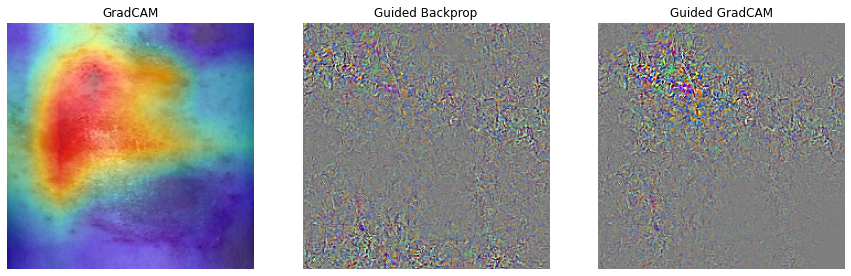

In [60]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

### **NM**

In [61]:
nm_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/nm/nm4.jpg'

Model prediction:
	nm             	(1)	with probability 0.967
	sk             	(3)	with probability 0.014
	ad             	(0)	with probability 0.012
	ps             	(2)	with probability 0.007
Explanation for 'nm'


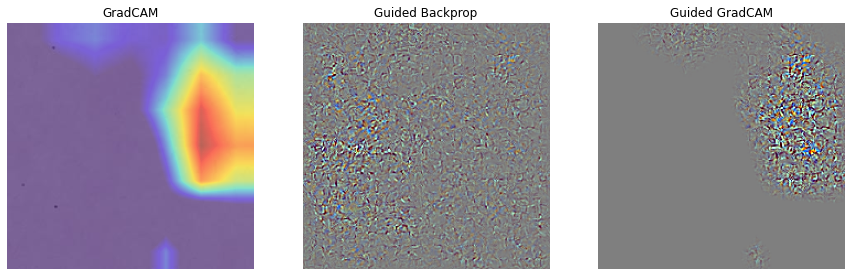

In [62]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, nm_img, layer_name=last_conv2d)

### **PS**

In [63]:
ps_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ps/ps57.jpg'

Model prediction:
	ps             	(2)	with probability 0.475
	ad             	(0)	with probability 0.216
	sk             	(3)	with probability 0.159
	nm             	(1)	with probability 0.151
Explanation for 'ps'


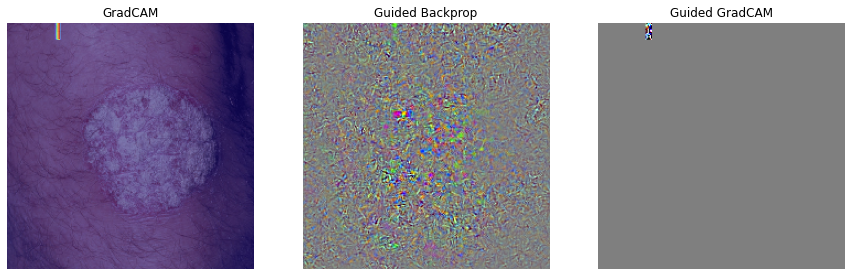

In [64]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ps_img, layer_name=last_conv2d)

### **SK**

In [65]:
sk_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/sk/sk4.jpg'

Model prediction:
	sk             	(3)	with probability 0.784
	ad             	(0)	with probability 0.159
	ps             	(2)	with probability 0.046
	nm             	(1)	with probability 0.011
Explanation for 'sk'


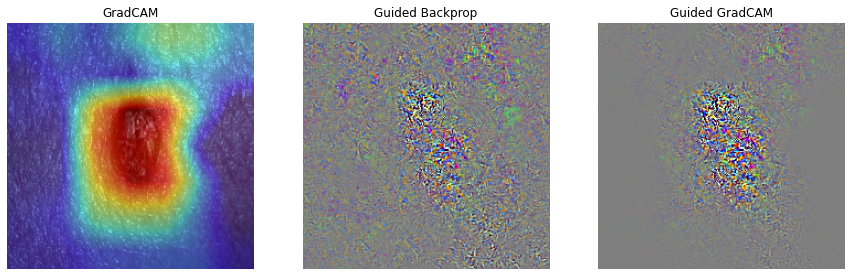

In [66]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, sk_img, layer_name=last_conv2d)